### Import necessary libraries and load the dataset

In [ ]:
!pip install opendatasets

In [ ]:
import tensorflow as tf # Tensorflow library
import keras # Keras library
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU,Rescaling, Dropout, concatenate # Keras library layers
from keras. layers import BatchNormalization, Conv2DTranspose, Concatenate, Lambda # Keras library layers
from keras.layers import Rescaling, Resizing # Keras library layers
from keras.models import Model, Sequential # Keras library model building constructors

from keras.optimizers import Adam # Adam optimizer
from keras.preprocessing.image import load_img # load images
from keras.utils import to_categorical # converts class vector (integers) to binary class matrix
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Callbacks
from tensorflow.keras import backend as K

import random # random number generator

import numpy as np # linear algebra library
import pandas as pd # tabular data processing library
import os # library for working with operating system functions, including files
import albumentations as A # image augmentation library (https://albumentations.ai/)

import matplotlib.pyplot as plt # library for drawing graphs
%matplotlib inline

import opendatasets as op

Let's load the dataset with the COVID-19 radiographic study data.

In [ ]:
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asugyfuyasdgf
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


Folder structure

In [ ]:
dataset_path = './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

image_dir = 'images'
label_dir = 'masks'

### Data Visualization

Let's take a look at the data that makes up our dataset.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'The original mask', 'The predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))            # display image
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5) # display mask with 50% transparency
    plt.axis('off')
  plt.show() # display the whole chart

Let's draw an example with the original image and a mask to it.

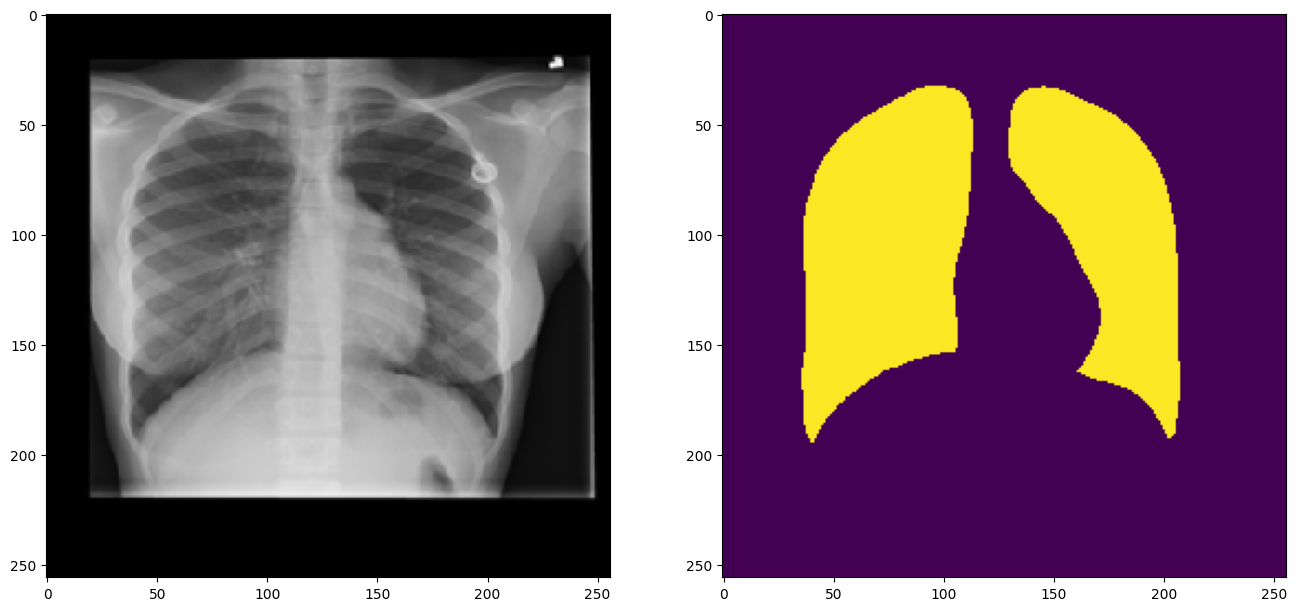

In [ ]:
original_image = os.path.join(dataset_path, image_dir, 'Normal-1.png')       # path to the original image
label_image_semantic = os.path.join(dataset_path, label_dir, 'Normal-1.png') # path to the mask

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # specify the area to be drawn (canvas)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # load the original image as RGB with 3 channels
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # load the mask as "grayscale", i.e. in one channel.

axs[0].imshow(img)  # render the original image
axs[0].grid(False)

axs[1].imshow(mask) # draw the mask (single channel image, each class is displayed as a separate color)
axs[1].grid(False)

### Creating a dataset for training

The dataset we downloaded contains a set of images. Let's create an array (list) of links to files with images `input_img_path` and masks `target_img_path`. To do this, we use a list generator with a condition to check the extension in the filename. The links are sorted to ensure that with the same index both lists will contain valid image-mask pairs.

In [ ]:
input_img_path = sorted(
    [
        os.path.join(dataset_path, image_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, image_dir))
        if fname.endswith(".png")
    ]
)

target_img_path = sorted(
    [
        os.path.join(dataset_path, label_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, label_dir))
        if fname.endswith(".png")
    ]
)

batch_size = 16
img_size = (128, 128) # The original size of 256x256 is reduced as resources are limited
IMG_CHANNELS = 3
NUM_CLASSES = 2

#### Using the sample generator **keras.utils.Sequence**

Using **keras.utils.Sequence** class you can implement your own sequence generator for training sample. Let's look at a concrete example of how this can be done.

Suppose we want to generate limited sample sets of digit images. To do this, let's define a derived class **datasetGenerator**, as follows:

In [ ]:
# Generator for data enumeration (as Numpy arrays)
class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = NUM_CLASSES, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation


    def __len__(self):
        """Returns the number of mini-batches of the training sample"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Returns the tuple (input, target) corresponding to the package index idx"""

        # Form packets from references by slicing the batch_size length and returning the packet by index
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Let's create a numpy array filled with zeros for the input data of the form(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 3) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        # Create a numpy array filled with zeros for the form output data (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) and uint8 data type
        y = np.zeros((self.batch_size, *self.img_size, NUM_CLASSES), dtype="uint8")

        # Fill the arrays with x and y images in a loop
        # Search for packets from batch_input_img_path and batch_target_img_path to images
        # zip returns for multiple sequences a list of tuples of sequence elements with the same indices
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Load the image and mask using the file system path
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 image channels
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))  # 1 mask channel

            if self.validation == False:
                # Apply augmentation to the test sample (p is the probability of application, 0.5 for every second image)
                transform = A.Compose([ # define augmentation function
                                A.HorizontalFlip(p=0.5), # Horizontal reflection of the image
                                A.VerticalFlip(p=0.5),
                                A.RandomRotate90(p=0.5) # Random rotation by 90 degrees
                                 ])
                transformed = transform(image=img, mask=mask) # apply the augmentation function to the image and mask
                img = transformed["image"]
                mask = transformed["mask"]
            # transform the mask: replace 255 with 1
            mask = np.where(mask == 255, 1, mask)
            x[_] = img / 255 # normalize the image
            y[_] = to_categorical(mask, num_classes=NUM_CLASSES) # convert the mask from integers to a binary class matrix

        return x, y

In [ ]:
np.unique(mask)

array([  0, 255], dtype=uint8)

Shuffle the data with the same `seed` to keep matching images and masks at the same index.

In [ ]:
seed = 1523
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

Let's split our dataset into training and verification samples. From the file README.md.txt we learn that the dataset contains 10192 images of lungs in normal condition.
For the test sample we will take only 1000 images.

In [ ]:
val_samples = 1000

# Split our dataset into training and validation samples
train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

Let's create instances of the class for our sample generator, initialize it with the split samples above.

In [ ]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, NUM_CLASSES)

val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, NUM_CLASSES, validation = True)

### Network architecture U-net++

Unet ++ is a powerful architecture for medical image segmentation. The architecture is a deeply emphasized encoder-decoder network where encoder and decoder subdivisions are connected through a series of nested, dense skip paths. Redefined skip connecyions aim to reduce the semantic gap between the feature maps of the encoder and decoder subdivisions.

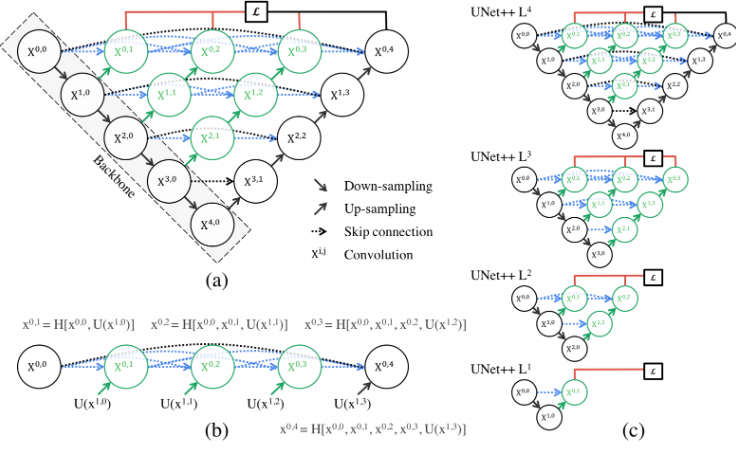

Model Parameters

In [ ]:
LR = 0.001

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

NUM_EPOCHS=25

Let's build the architecture of the model:

In [ ]:
tf.keras.backend.clear_session()
nb_filter = [32,64,128,256,512]
inputs = Input((img_size[0], img_size[1], IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(2, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model = Model([inputs], [nestnet_output_4])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=bce_dice_loss)

In [ ]:
model.summary() # model structure report

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_6[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 16, 16,    │          0 │ dropout_7[0][0] 

 Total params: 9,042,210 (34.49 MB)

 Trainable params: 9,042,210 (34.49 MB)

 Non-trainable params: 0 (0.00 B)

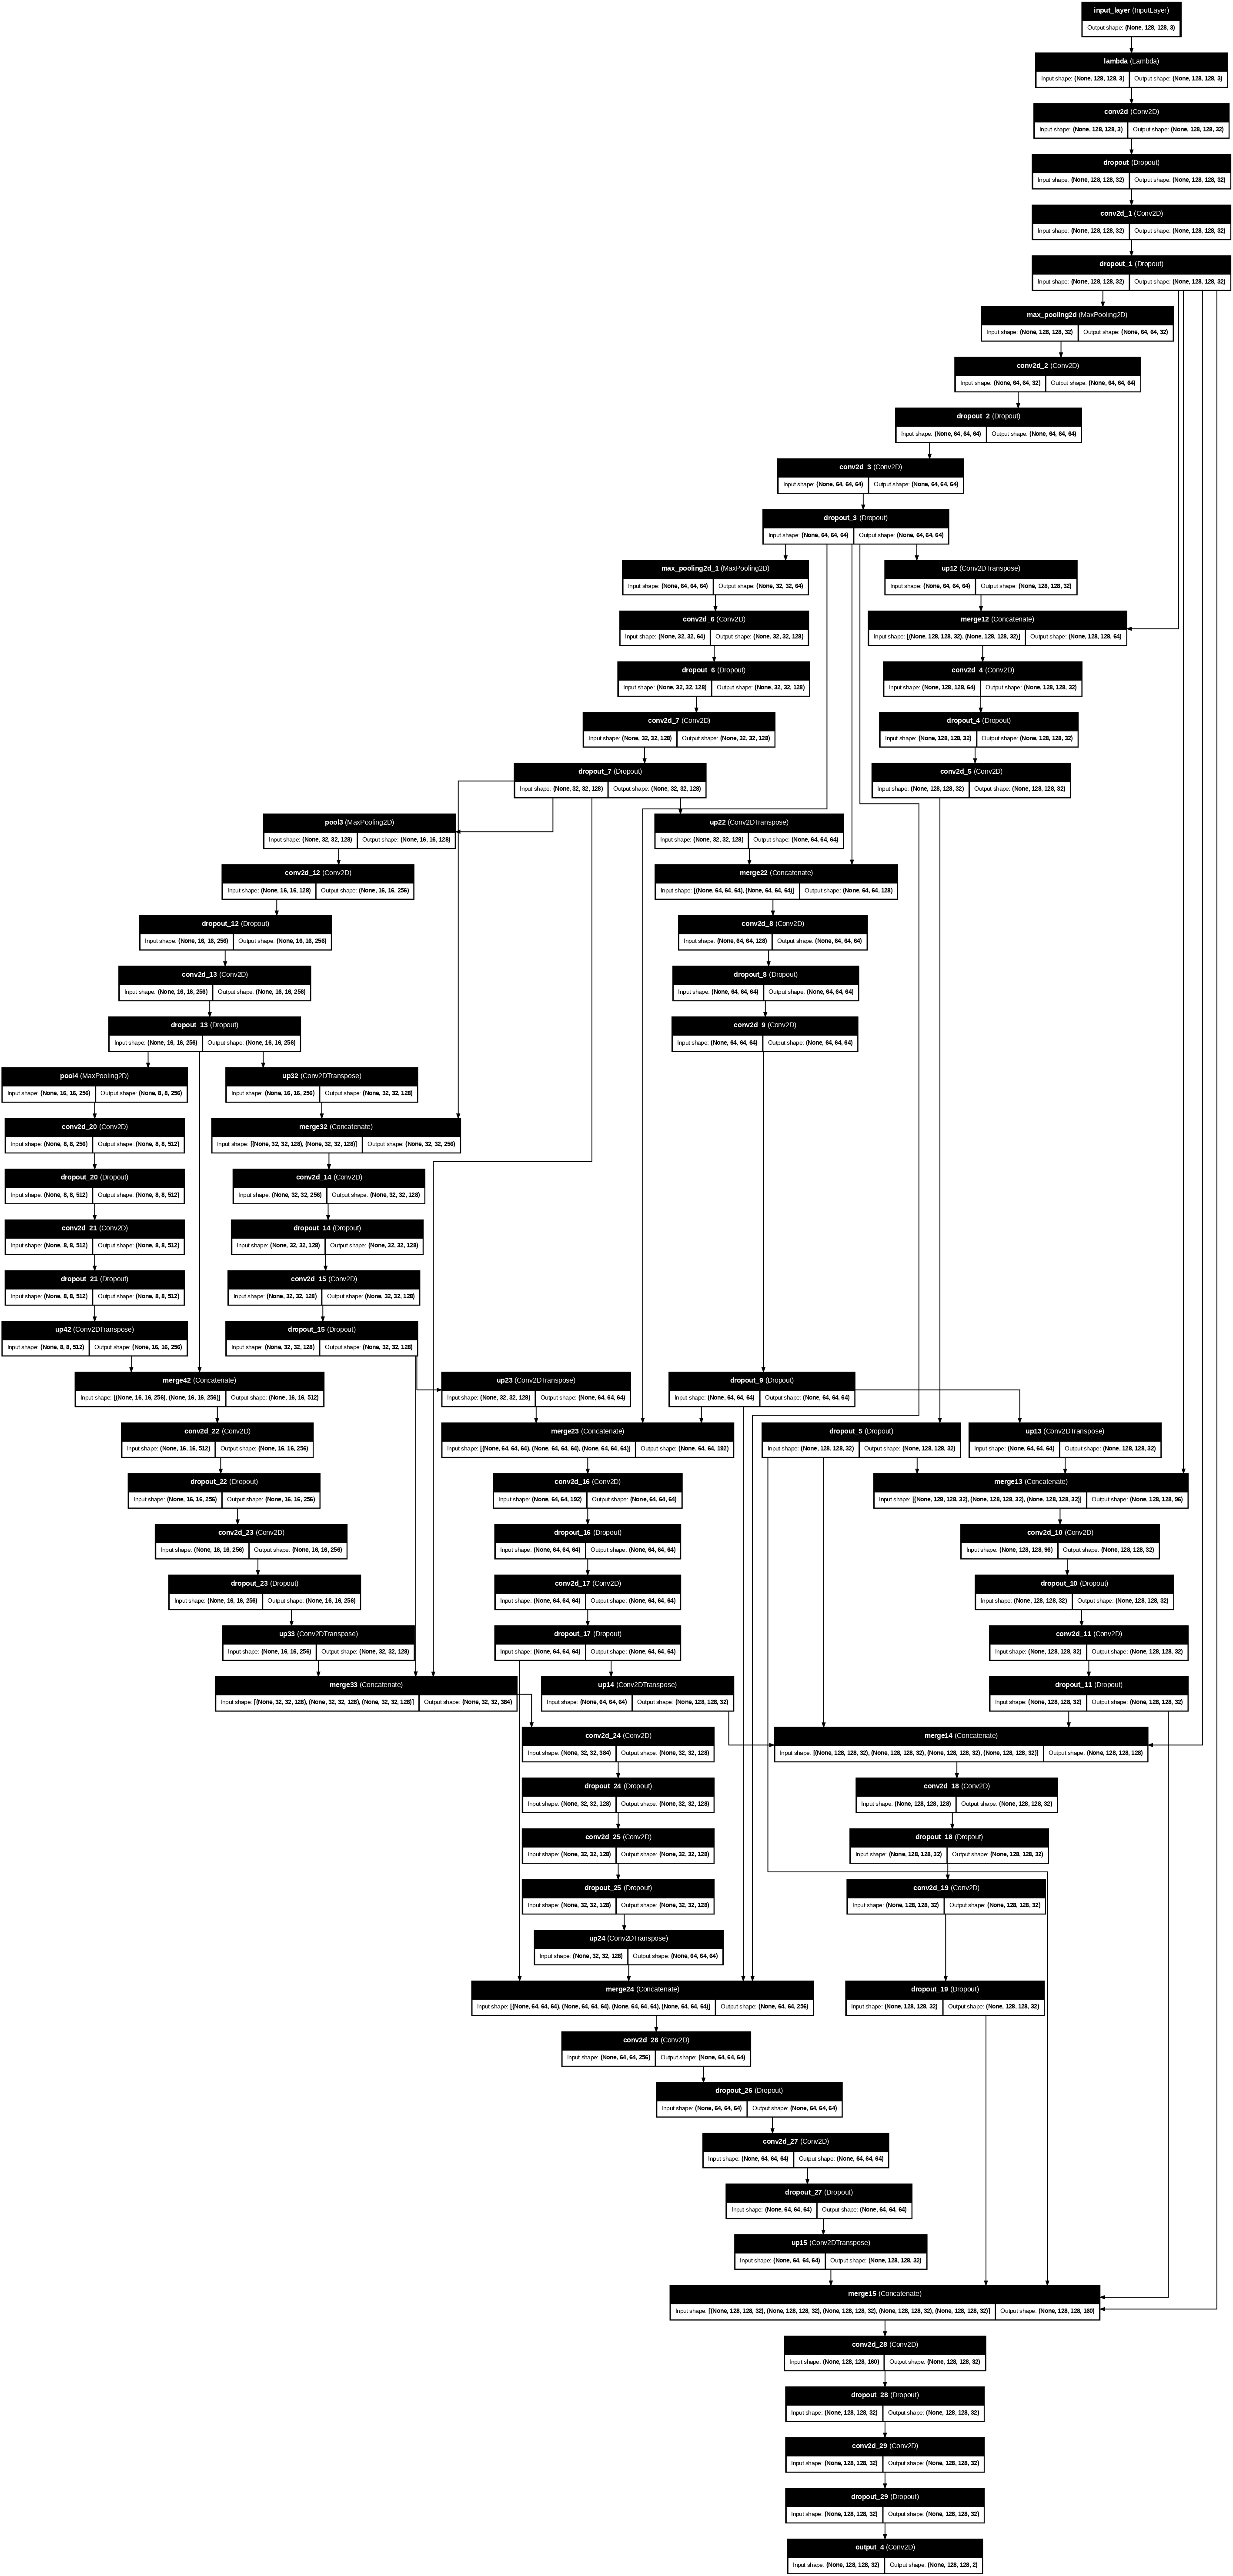

In [ ]:
# Model structure graph
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

### Model training

Now we can train our model by passing it instances of the sample generator class for training and validation samples. We will train it for 50 epochs.

In [ ]:
checkpoint = ModelCheckpoint('best_model.weights.h5' ,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only=True,
                             mode = 'min',
                             save_weights_only=True,
                             save_freq='epoch'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.00005)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    validation_steps=10,
                    batch_size=batch_size,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS,
                    verbose=1,)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: -0.7340
Epoch 1: val_loss improved from inf to -0.83054, saving model to best_model.weights.h5
574/574 ━━━━━━━━━━━━━━━━━━━━ 165s 229ms/step - loss: -0.7343 - val_loss: -0.8305 - learning_rate: 0.0010
Epoch 2/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: -0.9399
Epoch 2: val_loss improved from -0.83054 to -0.93729, saving model to best_model.weights.h5
574/574 ━━━━━━━━━━━━━━━━━━━━ 141s 246ms/step - loss: -0.9399 - val_loss: -0.9373 - learning_rate: 0.0010
Epoch 3/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: -0.9497
Epoch 3: val_loss did not improve from -0.93729
574/574 ━━━━━━━━━━━━━━━━━━━━ 128s 223ms/step - loss: -0.9497 - val_loss: -0.8540 - learning_rate: 0.0010
Epoch 4/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: -0.9569
Epoch 4: val_loss improved from -0.93729 to -0.95082, saving model to best_model.weights.h5
574/574 ━━━━━━━━━━━━━━━━━━━━ 129s 224ms/step - loss: -0.9569 - val_loss: -0.9508 - learning_rate:

### Analyzing learning outcomes

Let's look at the graph of accuracy and error function. We can see that still the accuracy is far from saturation and we can continue training. There is no overtraining yet.

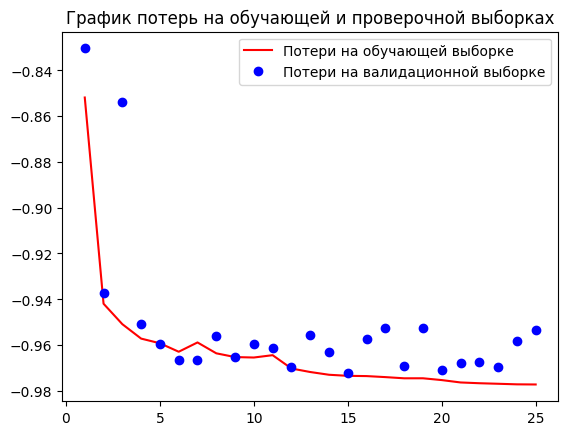

In [ ]:
loss = history.history['loss']                                             # error data on the training sample
val_loss = history.history['val_loss'] # error data on the test sample
epochs = range(1, len(loss) + 1) # array with values for the abscissa axis (X)
plt.figure() # create a new figure (canvas for the chart)
plt.plot(epochs, loss, 'r', label='Loss on training sample') # plot the loss (error) on the training sample
plt.plot(epochs, val_loss, 'bo', label='Losses on validation sample') # plot losses on validation sample
plt.title('Plot of losses on training and validation samples') # plot title
plt.legend() # plot legend
plt.show()

### Visual evaluation of the segmentation result on the test sample

Let's compare the original mask and the predicted mask on the test sample.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'The original mask', 'The predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0]) # display image
    plt.imshow(display_list[i],alpha=0.8) # display mask with transparency80%
    plt.axis('off')
  plt.show()

Let's define a mask creation function and display 10 sample images and their corresponding original and predicted masks.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


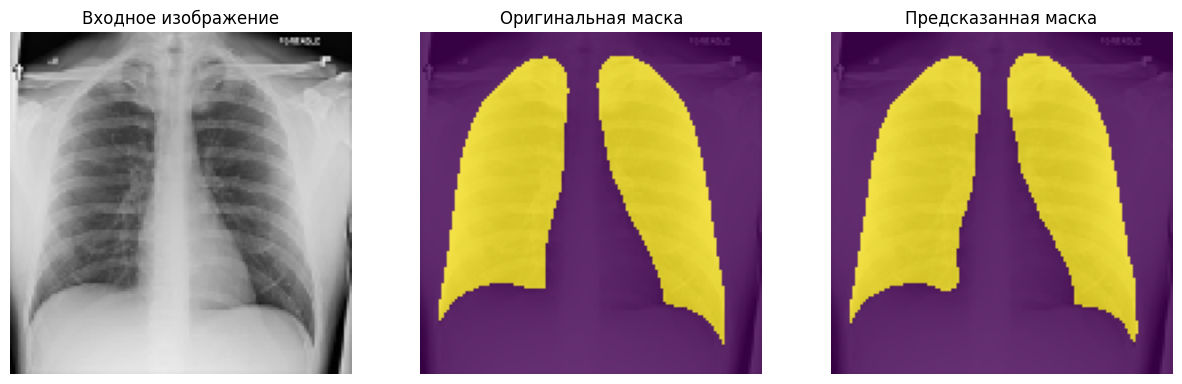

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


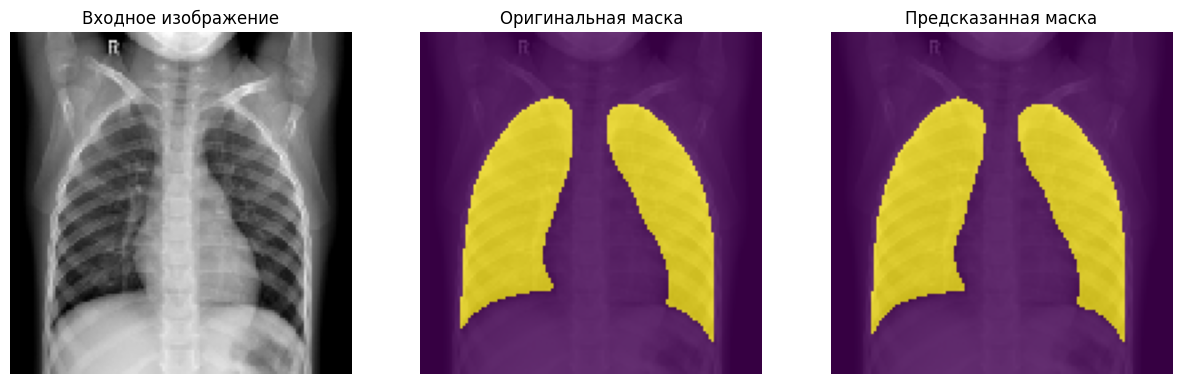

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


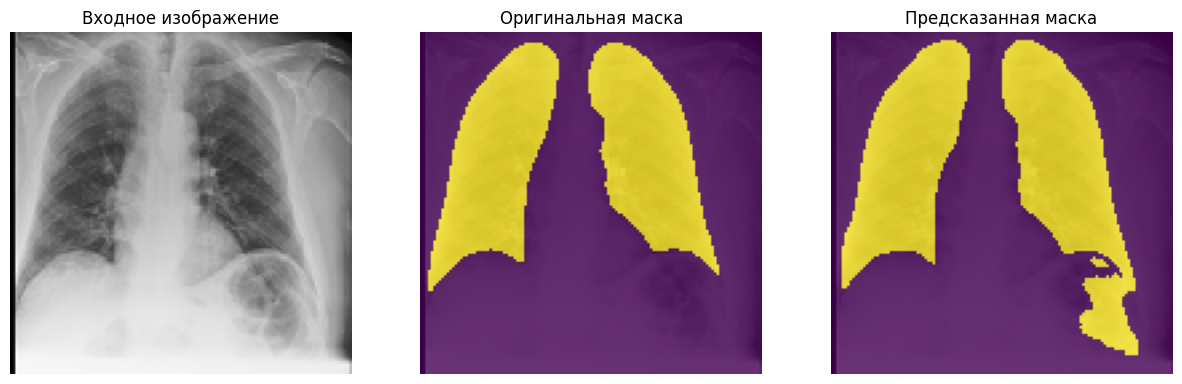

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


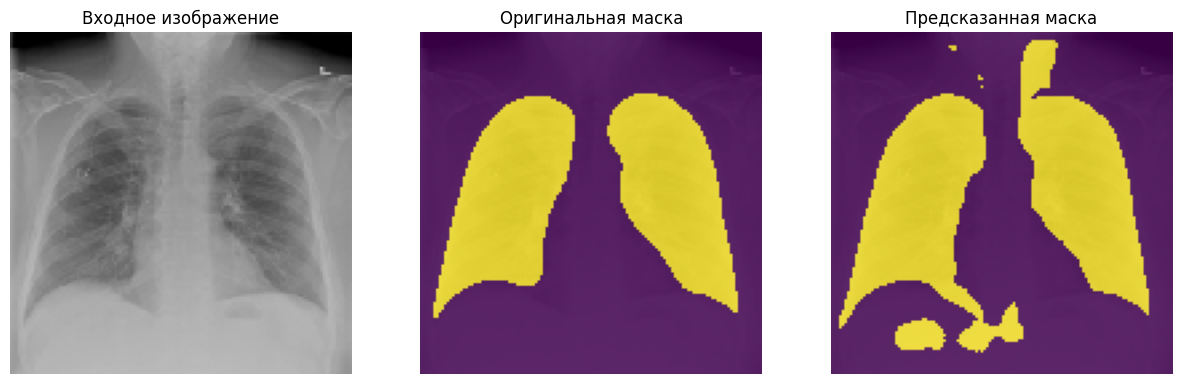

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


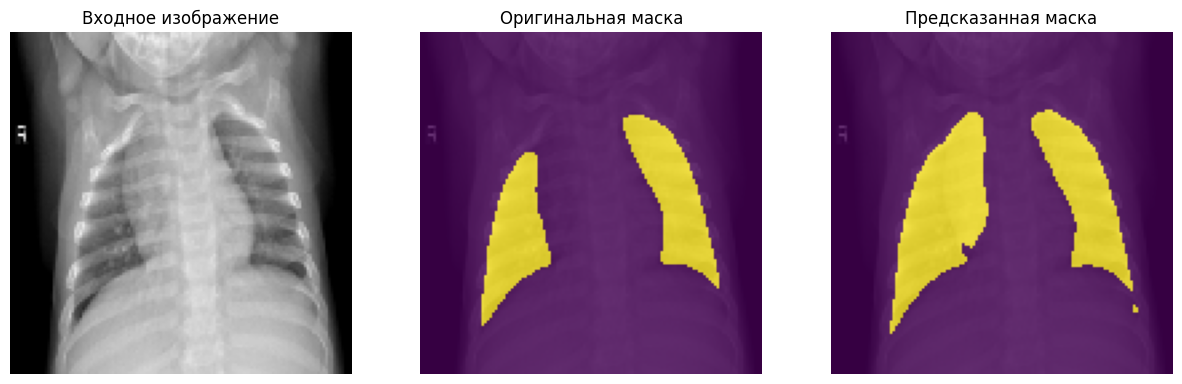

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


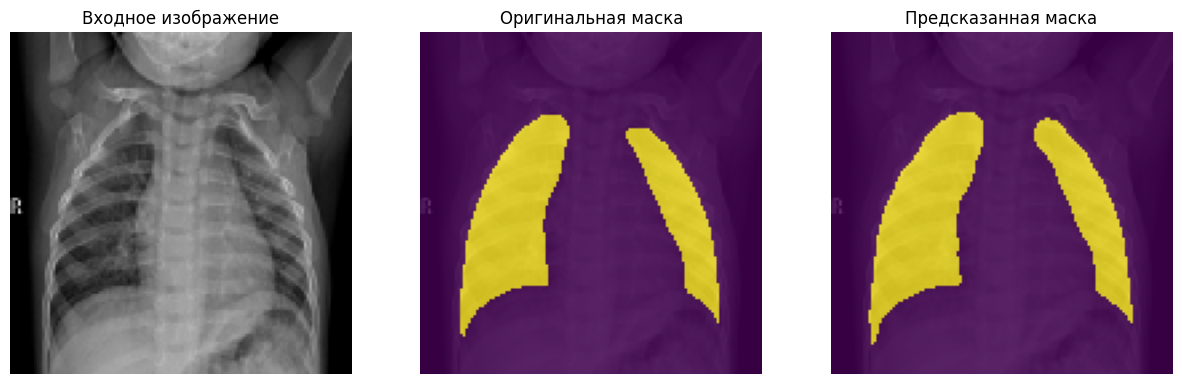

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


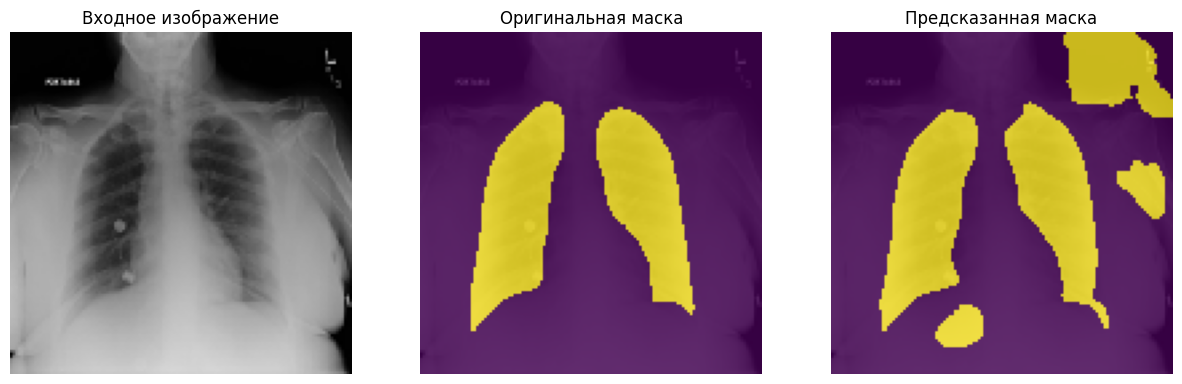

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


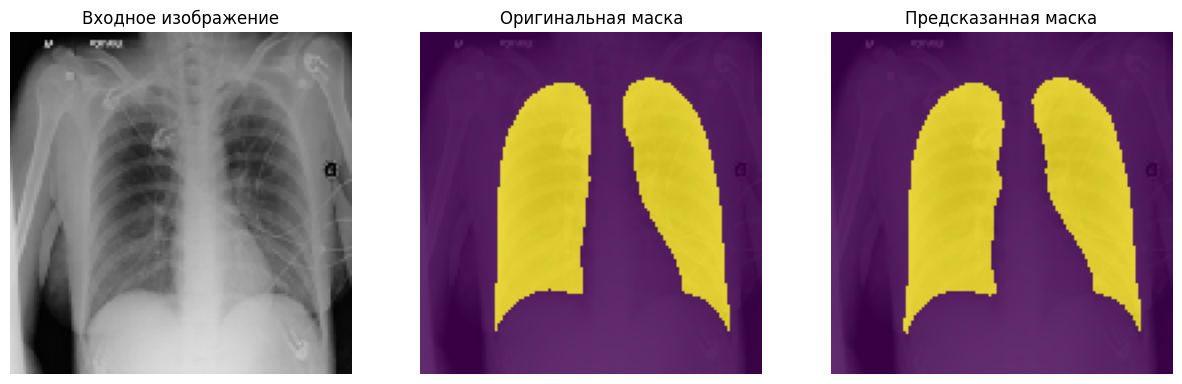

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


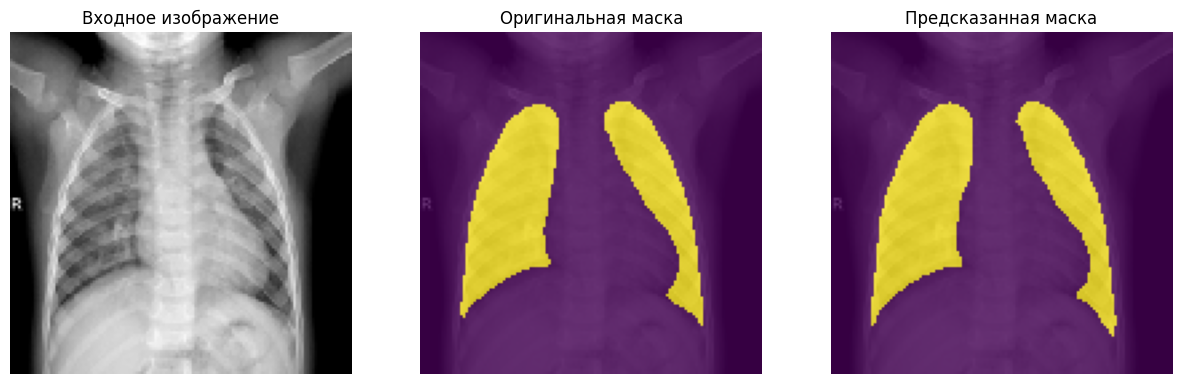

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [ ]:
for index in range(10): # select 10 images and display them in the loop
    img = np.array(load_img(val_input_img_path[index], target_size=(128, 128), color_mode='rgb')) # load image for prediction
    mask = np.array(load_img(val_target_img_path[index], target_size=(128, 128), color_mode='grayscale')) # load the mask for comparison with prediction

    # Run the model in prediction mode
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Select the most likely class
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 128, 128, 3)[0], mask, test[0]])  # pass the image, the original mask and the predicted mask to the display function